In [1]:
%matplotlib widget
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

'''
from matplotlib.ticker import LogFormatter 
from matplotlib import ticker, cm
import matplotlib as mpl
import copy
import os
import h5py
import json
import PyPDF2                       
import glob                         
from collections.abc import Iterable
import succolib as suc
import math
'''

import sys 
Swan_h = ("swan" in sys.executable) or ("cern" in sys.executable)
# print('Swan ', Swan_h)

In [2]:
## Select Year and Material ##

# # # # Simulazioni # # # # # # # # 
# year = 00
# material = 'W_2mm'

year = 2022
material = 'W_2mm'
# material = 'Ir_1mm' 
# material= 'Diamond'

# year = 2023
# material = 'W_1.5mm' 
# material = 'W_2.5mm' ##CRAP
# material = 'Ir_2mm'

# year = 2024
# material = 'W_1.5mm' 
# material = 'W_10mm' 
# material = 'Hybrid'

type_analysis = 'axial-random'
# type_analysis = 'transition'
# type_analysis = 'single'
check_randoms = False

In [3]:
import Utils
from Utils import *

Utils.Swan = Swan_h
Utils.Year = year
Utils.Material = material
print('SWAN ',Utils.Swan,'YEAR ',Utils.Year, material,'\n')

## Open config and correct offset dizionary ##

config_file = "./config_"+ material + '_' + str(year)[2:] +".json" 
print(config_file)

with open(config_file, "r") as f:
            dizi = json.load(f)   
dizi
if (dizi['offset_y2'] == 0 or dizi['offset_x2'] == 0) & year != 00:
    input("CHECK THE ALIGNMENT, OFFSETS = 0")
else:
    print('\noffset_x2 ', dizi['offset_x2'])
    print('offset_y2 ', dizi['offset_y2'])
mycmap = 'jet'

SWAN  False YEAR  2022 W_2mm 

./config_W_2mm_22.json

offset_x2  -0.3527684476616023
offset_y2  0.1291983682460753


550219  -  6 GeV
550220  -  5 GeV
550221  -  4 GeV
550222  -  3 GeV
550223  -  2 GeV
550224  -  1 GeV
[8954.0, 7406.588971462455, 5962.0, 4422.0, 3014.0, 1430.0] [240.0, 374.34053332668185, 208.0, 180.0, 144.0, 108.0]


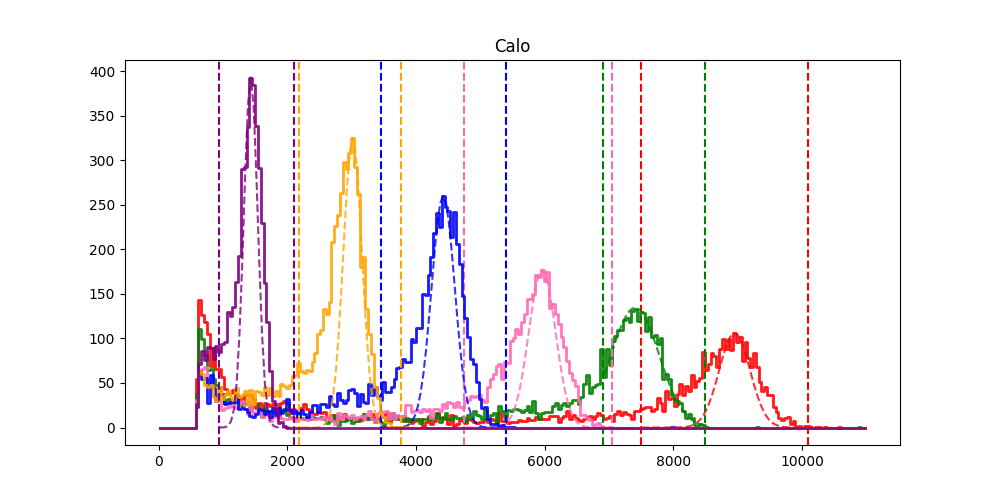

In [32]:
if year == 2023:
        n_bin_calo = 500
        n_bin_APC1 = 100
        n_bin_APC2 = 100
        Calo_th = 100
        APC1_th = 0
        APC2_th = 0
        C_range = [0,8000]
        fit_range_min = [6000,4300,3380,2650,1450,540]
        fit_range_max = [7000,6600,5280,4100,2900,1470]
        runs = [j for j in range(680542,680548)]
if (year == 2022) and (material == ( "W_2mm") or material == ("Ir_1mm")) :
        n_bin_calo = 250
        n_bin_APC1 = 100
        n_bin_APC2 = 100
        Calo_th = 600
        APC1_th = 0
        APC2_th = 0
        C_range = [0,11000]
        fit_range_min = [7500,6900,4750,3450,2180,930]
        fit_range_max = [10100,8500,7050,5400,3770,2100]
        runs = [j for j in range(550219,550225)]
        
if year == 2024 : ## e+BOOST CON APC
        n_bin_calo = 100
        n_bin_APC1 = 100
        n_bin_APC2 = 100
        Calo_th = 60
        APC1_th = 0
        APC2_th = 0
        C_range = [0,1500]
        fit_range_min = [800,700,550,350,200,60]
        fit_range_max = [1400,1200,900,750,500,300]
        runs = [j for j in range(720649,720655)]

plot_APC = False
if plot_APC:
        fig, ax = plt.subplots(3)
        fig.set_size_inches(10,12.5)
else:
        fig, ax = plt.subplots(1)
        fig.set_size_inches(10,5)
       
labels = ['6 GeV','5 GeV','4 GeV','3 GeV','2 GeV','1 GeV']
colors = ['red', 'green','hotpink',  'blue', 'orange', 'purple', ]

# runs = [j for j in range(680299,680305)]
# labels = ['1 GeV','2 GeV','3 GeV','4 GeV','5 GeV','6 GeV']
opt = { "lw" : 2,"alpha" : 0.9 }
En_values=[]
sigma_values=[]
for i, run in enumerate(runs):
# for i, run in enumerate(runs[:-2]]):
    print( run ,' - ', labels[i])
    if year == 2024: 
        xpos,xinfo,ph,tm,evi,info_plus,ph_cherry1,ph_cherry2,ph_scinti_desy,ph_scinti_after_magnet,ph_calo_photon,\
                ph_calo_elect1,ph_calo_elect2,ph_apc1,ph_apc2,x1,y1,x2,y2,x_cry,y_cry,theta_in_x,theta_in_y = file_corrector(run)
    elif (year == 2023) or (year == 2022):
        pos,xinfo,ph,tm,evi,Cherry,ph_calo_photon,ph_apc1,ph_apc2,x1,y1,x2,y2,x_cry,y_cry = file_corrector(run)
#     print(np.shape(ph_calo_photon))
    h, bins = np.histogram(ph_calo_photon[ph_calo_photon>Calo_th], n_bin_calo,range = C_range)#, label = (str(Beam_en[i])+' GeV'))
    
#     print (fit_range_min[i],fit_range_max[i])
    binc = bins[:-1] + (bins[1] - bins[0]) / 2
    fit_range = (binc >= fit_range_min[i]) & (binc <= fit_range_max[i])

    x_fit = binc[fit_range]
    y_fit = h[fit_range]
       
    ##guesses
    p0 = (max(y_fit), x_fit[np.argmax(y_fit)], (4)*len(x_fit))
    p02 = (max(y_fit), x_fit[np.argmax(y_fit)],100)
#     print(p0)
    
    fit_popt, pcov = curve_fit(myGauss, x_fit, y_fit, sigma = np.sqrt(y_fit), absolute_sigma = True, p0 = p0)
#     fit_popt, pcov = curve_fit(myGauss, x_fit, y_fit, sigma = np.sqrt(y_fit), absolute_sigma = True)#, p0 = p0)
    # fit_popt2, pcov2 = curve_fit(my_landau, x_fit, y_fit, sigma = np.sqrt(y_fit), absolute_sigma = True, p0 = p02)

    En_values.append(fit_popt[1])
    sigma_values.append(fit_popt[2])

    if plot_APC:
        ax[0].plot(binc, h, ds = "steps-mid", lw = 2,alpha = 0.9, label=labels[i])
        ax[0].set_title('Calo')
        # ax.axvline(fit_range_max[i])
        # ax.axvline(fit_range_min[i])
        # ax[0].hist(Calo[Calo>Calo_th],n_bin_calo, alpha = 0.3, label=labels[i], range = [0,8000])
        # ax[0].set_yscale('log')    
    
        ax[0].plot(x_fit, myGauss(x_fit, *fit_popt), ls = "--", label = f"fit ({fit_popt[1]:.2f} $\pm$ {fit_popt[2]:.2f}) ")
        # ax[0].plot(x_fit, my_landau(x_fit, *fit_popt2), ls = "--", label = f"landau) ")
        ax[0].grid()
        
        ax[1].hist(APC1[APC1>APC1_th],n_bin_APC1,[0,100], alpha = 0.3)
        ax[1].set_title('APC1')
        ax[1].set_yscale('log')

        ax[2].hist(APC2,n_bin_APC2,[0,100],alpha = 0.3)
        ax[2].set_title('APC2')
        ax[2].set_yscale('log')
    else:
        ax.plot(binc, h, ds = "steps-mid", c= colors[i], label=labels[i], **opt)
        ax.set_title('Calo')
        ax.plot(x_fit, myGauss(x_fit, *fit_popt), c= colors[i], alpha=0.8, ls = "--", label = f"fit ({fit_popt[1]:.2f} $\pm$ {fit_popt[2]:.2f}) ")
        # ax.plot(x_fit, my_landau(x_fit, *fit_popt2),c= colors[i], ls = "-", label = f"landau")
        ax.grid()
        ax.axvline(fit_range_min[i],ls='--',c = colors[i])
        ax.axvline(fit_range_max[i],ls='--',c = colors[i])
        # ax.set_ylim(0,1000)
        # ax.set_yscale('log')
           

    

print(En_values,sigma_values)
# ax[0].legend(fontsize = 10)
plt.show()

    

slope_Calo 1595.125, intercept_Calo 21.918


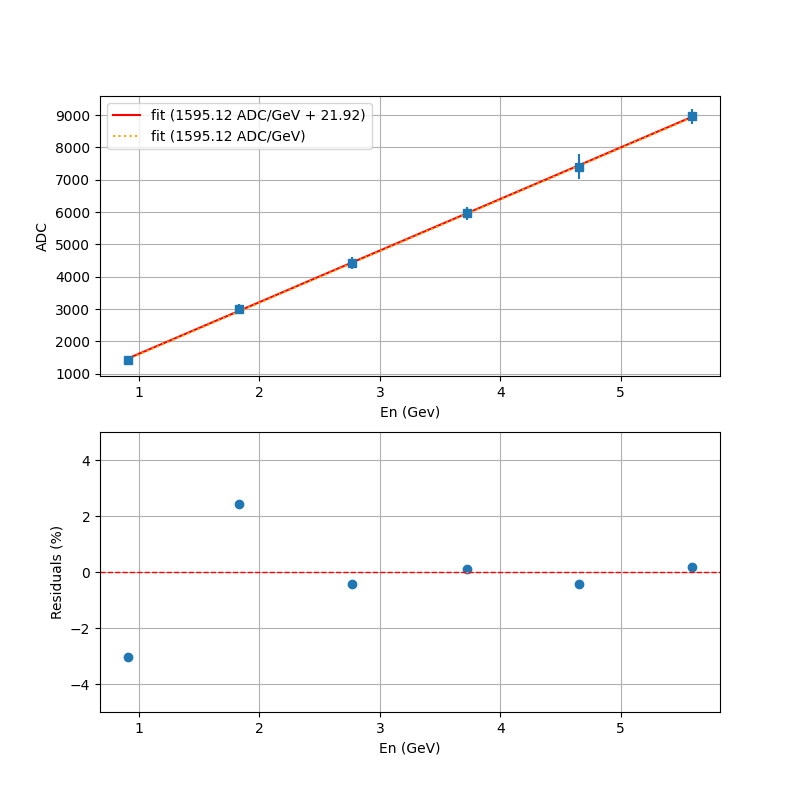

In [33]:
fig, ax = plt.subplots(2)
fig.set_size_inches(8,8)

# Beam_en = [6,     5,      4,     3,    2,   1 ]
# Beam_en =   [5.72,  4.77, 3.81,  2.86, 1.91,  0.95  ]
# Beam_en =   [5.67,  4.72, 3.78,  2.83, 1.89,  0.95  ]
Beam_en =   (5.59, 4.65, 3.72, 2.77, 1.83, 0.91) 
# Beam_en = [1,2,3,4,5,6]
ax[0].errorbar(Beam_en,En_values,sigma_values,marker='s',ls='')

slope, intercept = np.polyfit(Beam_en, En_values, 1)
y_predicted = np.polyval([slope,intercept], Beam_en)

residuals = ((En_values - y_predicted)/ En_values) * 100

fit_line = slope * np.array(Beam_en) + intercept
NewData={"slope_Calo": slope, "intercept_Calo": intercept}
dizi.update(NewData)
fit_minusq=slope * np.array(Beam_en)


# Plot the linear fit
ax[0].plot(Beam_en, fit_line, color='red', label=f"fit ({slope:.2f} ADC/GeV + {intercept:.2f})")
ax[0].plot(Beam_en, fit_minusq, color='orange', ls =':', label=f"fit ({slope:.2f} ADC/GeV)")
ax[0].set_xlabel('En (Gev)')
ax[0].set_ylabel('ADC')
ax[0].grid()
ax[0].legend()

ax[1].scatter(Beam_en,residuals)
ax[1].set_xlabel('En (GeV)')
ax[1].set_ylabel('Residuals (%)')
ax[1].set_ylim(-5,5)
ax[1].axhline(y=0, color='red', linestyle='--', linewidth=1)
ax[1].grid()

print(f"slope_Calo {slope:.3f}, intercept_Calo {intercept:.3f}")
plt.show()
##### upload new element to the json file 
# print(config_file)
# with open(config_file, "w") as f:
#             json.dump(dizi, f, indent=4)

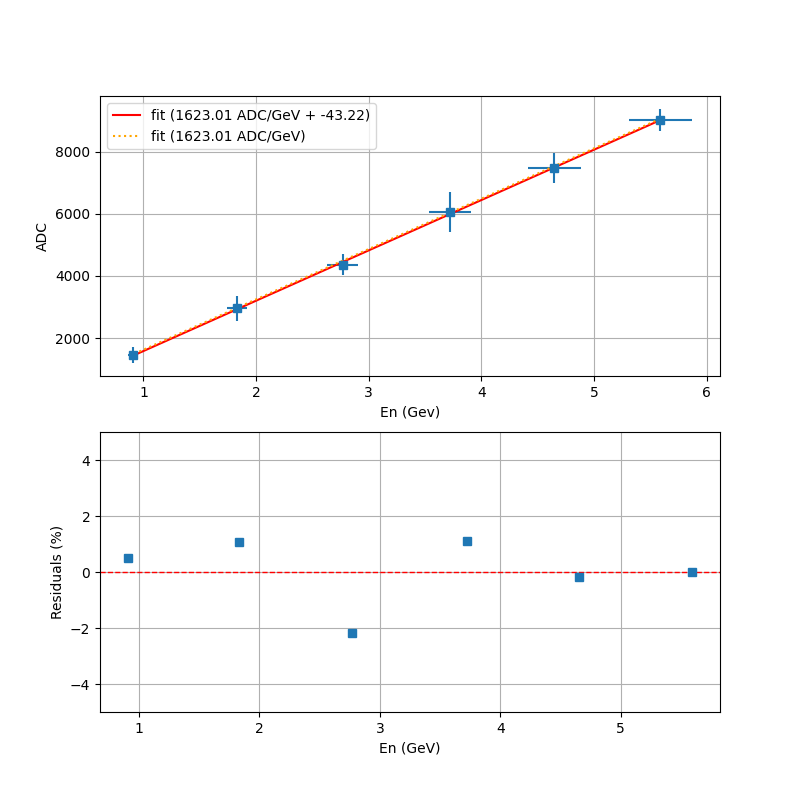

m : 1623.012  q: -43.221


In [6]:
fig, ax = plt.subplots(2)
fig.set_size_inches(8,8)
en_spread = 0.05
# Beam_en = [6,5,4,3,2,1]
Beam_error = [e*en_spread for e in Beam_en]
# print(Beam_error)
# Beam_en = [1,2,3,4,5,6]
ax[0].errorbar(Beam_en,En_values,xerr=Beam_error,yerr=sigma_values,marker='s',ls='')

slope, intercept = np.polyfit(Beam_en, En_values, 1)
y_predicted = np.polyval([slope,intercept], Beam_en)

residuals = ((En_values - y_predicted)/ En_values) * 100

fit_line = slope * np.array(Beam_en) + intercept
NewData={"slope_Calo": slope, "intercept_Calo": intercept}
dizi.update(NewData)
fit_minusq=slope * np.array(Beam_en)


# Plot the linear fit
ax[0].plot(Beam_en, fit_line, color='red', label=f"fit ({slope:.2f} ADC/GeV + {intercept:.2f})")
ax[0].plot(Beam_en, fit_minusq, color='orange', ls =':', label=f"fit ({slope:.2f} ADC/GeV)")
ax[0].set_xlabel('En (Gev)')
ax[0].set_ylabel('ADC')
ax[0].grid()
ax[0].legend()

ax[1].errorbar(Beam_en,residuals,marker='s',ls='')
ax[1].set_xlabel('En (GeV)')
ax[1].set_ylabel('Residuals (%)')
ax[1].set_ylim(-5,5)
ax[1].axhline(y=0, color='red', linestyle='--', linewidth=1)
ax[1].grid()

plt.show()
print(f'm : {slope:.3f}  q: {intercept:.3f}')
##### upload new element to the json file 
# print(config_file)
# with open(config_file, "w") as f:
#             json.dump(dizi, f, indent=4)

In [7]:
print(np.max('pippo'))

UFuncTypeError: ufunc 'maximum' did not contain a loop with signature matching types (dtype('<U5'), dtype('<U5')) -> None

In [ ]:
runs =680476
if year == 2023:
        n_bin_calo = 1500
        APC1_th = 20
        APC2_th = 50
        Calo_th = 100
        n_bin_APC1 = 200
        n_bin_APC2 = 500


xpos,xinfo,ph,tm,evi,Cherry,Calo,APC1,APC2,x1,y1,x2,y2,x_cry,y_cry = file_corrector(runs)
fig, ax = plt.subplots(2)

ax[0].hist(APC1[APC1>APC1_th],n_bin_APC1, alpha = 0.3, range = [0,1000], density = True)
ax[0].set_title('APC1')
ax[0].set_yscale('log')

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

hist, bin_edges = np.histogram(APC2[APC2 > APC2_th], bins=n_bin_APC2, range=[0, 10000])

bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

fit_min = 50
fit_max = 800
fit_range = (bin_centers >= fit_min) & (bin_centers <= fit_max)

params, covariance = curve_fit(landau, bin_centers[fit_range], hist[fit_range], p0=[1000, 200, 10])

A_fit, mu_fit, c_fit = params

x_fit = np.linspace(fit_min, fit_max, 1000)
y_fit = [landau(xi, A_fit, mu_fit, c_fit) for xi in x_fit]

ax[1].hist(APC2[APC2 > APC2_th], bins=n_bin_APC2, alpha=0.3, range=[0, 10000], label='Data')
ax[1].set_yscale('log')
ax[1].set_title('APC2')

ax[1].plot(x_fit, y_fit, 'r-', label='Landau Fit')
ax[1].axvline(x=mu_fit, color='g', linestyle='--', label=f'Peak at {mu_fit:.2f}')
ax[1].legend()
